In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RAW_interactions = pd.read_csv('data/RAW_interactions.csv')
RAW_recipes = pd.read_csv('data/RAW_recipes.csv')
RAW_interactions.shape

(1132367, 5)

In [3]:
interactions_test = pd.read_csv('data/interactions_test.csv')
interactions_train = pd.read_csv('data/interactions_train.csv')

In [4]:
interactions_test.recipe_id.isin(interactions_train.recipe_id.unique()).sum()

0

In [5]:
RAW_recipes[RAW_recipes["id"].isin([2496, 205890])]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
69688,dark chocolate cake,2496,60,1535,1999-10-23,"['60-minutes-or-less', 'time-to-make', 'course...","[189.1, 10.0, 80.0, 10.0, 5.0, 7.0, 10.0]",17,"['heat oven to 350f', 'grease and flour two 9 ...",while it takes slightly longer to prepare this...,"['sugar', 'flour', 'baking cocoa', 'baking pow...",11
190962,soft peanut butter cookies,205890,17,166642,2007-01-16,"['30-minutes-or-less', 'time-to-make', 'course...","[201.7, 16.0, 58.0, 6.0, 7.0, 24.0, 7.0]",7,"['cream butter , peanut butter and both sugars...",this is my mother-in-law's recipe.she was alwa...,"['creamy peanut butter', 'brown sugar', 'white...",9


In [6]:
print(f"Nombre d'utilisateurs: {len(RAW_interactions.user_id.unique())}")
print(f"Nombre de recettes: {len(RAW_interactions.recipe_id.unique())}")

Nombre d'utilisateurs: 226570
Nombre de recettes: 231637


In [7]:
RAW_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [8]:
print(f"Shape train avant filtrage: {RAW_interactions.shape}")

# filter recipe
RAW_interactions['count'] = RAW_interactions.groupby('recipe_id').transform('count')['user_id']
movieId = RAW_interactions.drop_duplicates('recipe_id').sort_values(
    'count', ascending=False).iloc[:100]['recipe_id']
RAW_interactions = RAW_interactions[RAW_interactions['recipe_id'].isin(movieId)].reset_index(drop=True)

#filter users
RAW_interactions['count'] = RAW_interactions.groupby('user_id').transform('count')['recipe_id']
user_id = RAW_interactions.drop_duplicates('user_id').sort_values(
    'count', ascending=False).iloc[:1000]['user_id']
RAW_interactions = RAW_interactions[RAW_interactions['user_id'].isin(user_id)].reset_index(drop=True)

print(f"Shape train après filtrage: {RAW_interactions.shape}")

Shape train avant filtrage: (1132367, 5)
Shape train après filtrage: (11699, 6)


In [9]:
pivot_train = RAW_interactions.pivot_table(index = ["user_id"],columns = ["recipe_id"],values = "rating")#, fill_value=0)
pivot_train.head(10)

recipe_id,2496,2886,3470,4627,5170,8701,8782,9272,9836,10744,...,131018,132263,135350,141983,150384,150863,200296,205890,261889,349246
user_id,,,,,,,,,,,,,,,,,,,,,
1535,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
4439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7108,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8629,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8688,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN
9717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
recipe_vector = pivot_train[2496]
similarity = pivot_train.corrwith(recipe_vector) 
similarity = similarity.sort_values(ascending=False)
similarity.head()

recipe_id
2496      1.000000
205890    1.000000
32844     0.935414
33921     0.889001
71373     0.887244
dtype: float64

## NCF

In [11]:
from tqdm import tqdm
import torch
import torch.nn as nn
from statistics import mean
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #Creating a train and a test set
testset = RAW_interactions.sample(frac=0.1, replace=False)
trainset = RAW_interactions[~RAW_interactions.index.isin(testset.index)]

assert set(testset.user_id.unique()).issubset(trainset.user_id.unique())
assert set(testset.recipe_id.unique()).issubset(trainset.recipe_id.unique())

In [12]:

class Ratings_Dataset(Dataset):
    def __init__(self, df):
        user_list = df.user_id.unique()
        item_list = df.recipe_id.unique()
        self.user2id = {w: i for i, w in enumerate(user_list)} # {user1: 0, user2: 1, ...}
        self.item2id = {w: i for i, w in enumerate(item_list)} # {item1: 0, item2: 1, ...}
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, idx):
        user = self.user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = self.item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Dataset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Dataset(testset), batch_size=64, num_workers=2)

In [13]:
def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.to(device)
            items = items.to(device)
            r = r.to(device) / 5  # normalize ratings to [0, 1]
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss):.4f}")
            
            
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=12):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        
        
    def forward(self, user, item):

        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

In [14]:
n_user = trainset.user_id.nunique()
n_items = trainset.recipe_id.nunique()
model = NCF(n_user, n_items).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=10)

loss: 0.0349: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


In [15]:
import math

def test(model, testloader):

    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.to(device)
            items = items.to(device)
            y = r.to(device) / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
        
            running_mae += error
            total += y.size(0)
            
    
    mae = running_mae/total
    return mae * 5
    

print(f"MAE sur les données de test: {test(model, testloader):.3f}")

MAE sur les données de test: 0.617


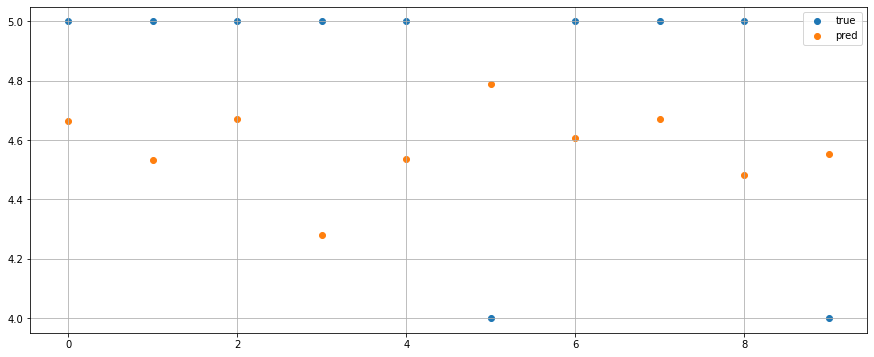

In [16]:
users, recipes, r = next(iter(testloader))
users = users.to(device)
recipes = recipes.to(device)
r = r.to(device)

y = model(users, recipes)*5
plt.figure(figsize=(15,6))
plt.scatter(range(10), r[:10].data)
plt.scatter(range(10), y.flatten()[:10].data)
plt.legend(["true", "pred"])
plt.grid();

### Sauvegarde des poids du modèle

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')